In [1]:
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir(r"C:\Users\j\gitlab\tierli_ahluege")

In [3]:
dino_list = list(np.load("./competition_data/grounding_dino/train/grounding_dino_last_calc.npy",allow_pickle=True))
def preprocessing(dino_list):
    def delete_animal_multi_label(animal):
        if len(animal[2]) > 1:
            logic = animal[2] != "animal"
            return [values[logic] for values in animal]
        else:
            return animal
    def max_confidence_multilabel(animal):
        if len(animal[2]) > 1:
            logic = animal[1].argmax()
            return [values[logic] for values in animal]
        else:
            return animal
    def format_better(animal):
        if type(animal[1]) == np.ndarray:
            animal[1] = animal[1][0]
            animal[0] = animal[0][0]
        return animal
    def nan_for_no_animals(animal):
        if len(animal[0]) == 0:
            return [np.nan,np.nan,np.nan]
        else:
            return animal
    def split_combined_labels(animal):
        if len(animal[0]) == 0:
            return animal
        elif type(animal[2]) == np.ndarray:
            animal[2] = animal[2][0]
        splitted = animal[2].split(" ")
        
        if len(splitted) == 2:
            animal[2] = splitted[splitted != "animal"]
            if type(animal[2]) == list:
                animal[2] = "animal"
        else:
            animal[2] = splitted[0]
        return animal
    dino_list = [delete_animal_multi_label(animal) for animal in dino_list]
    dino_list = [max_confidence_multilabel(animal) for animal in dino_list]
    dino_list = [split_combined_labels(animal) for animal in dino_list]

    dino_list = [nan_for_no_animals(animal) for animal in dino_list]
    dino_list = [format_better(animal) for animal in dino_list]
    df_dino = pd.DataFrame(dino_list,columns=["Boxes","Logits","Phrases"])
    return df_dino

In [4]:
df_dino = preprocessing(dino_list)


In [5]:
dino_list = list(np.load("./competition_data/grounding_dino/test/grounding_dino_test3500.npy",allow_pickle=True))
df_test = preprocessing(dino_list)

(array([ 50.,   0., 129.,   0.,   0., 149.,   0.,  87.,   0.,  16.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

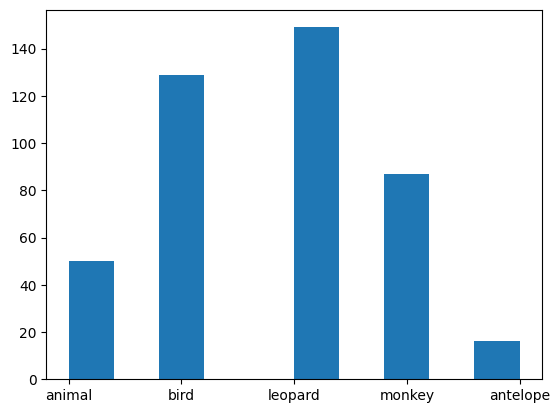

In [6]:
animal_test = df_test.dropna()[df_test.dropna()["Logits"] >0.5]
plt.hist(animal_test["Phrases"])

In [16]:
submit = pd.read_csv(r"C:\Users\j\Desktop\models_data\submit.csv")

In [17]:
def max_confidence(submit,dino_path ="./competition_data/grounding_dino/test/grounding_dino_test3500.npy" ):
    dino_list = list(np.load(dino_path,allow_pickle=True))
    df_test = preprocessing(dino_list)

    submit["argmax"] = submit.copy().set_index("id").values.argmax(axis=1)
    submit_join = submit.join(df_test).dropna()
    submit_join["argmax"] = submit_join["argmax"].replace({0:"antelope",1:"bird",2:"blank",3:"civet_genet",4:"hog",5:"leopard",6:"monkey",7:"rodent"})
    submit_join=submit_join[submit_join["Logits"]>0.6]
    submit_join=submit_join[submit_join["Phrases"] !="animal"]
    submit_join = submit_join[(submit_join["argmax"] == submit_join["Phrases"])]
    submit_join = submit_join.drop(columns=["argmax","Boxes","Logits","Phrases"])
    good_values = submit_join.copy().set_index("id").rank(1, ascending=False, method='dense').eq(1.).astype(float)
    submit = submit.set_index("id").drop(columns=["argmax"])
    print(len(good_values.index))
    submit.loc[good_values.index] = good_values.values
    return submit

In [18]:
submission = max_confidence(submit)#.to_csv("submit_new.csv")

203


In [461]:
df_train = pd.read_csv("./competition_data/train_labels.csv")
df_train=pd.melt(df_train,id_vars= "id")
df_train=df_train[df_train["value"]==1]
df_train=df_train.sort_values("id").reset_index(drop=True).rename(columns={"variable":"label"}).drop(columns="value")

df_train = pd.merge(df_train,pd.read_csv("./competition_data/trainfeatures_megadet_bbox_split.csv").loc[:,["id","conf"]],on="id")

In [23]:
df_merged = df_train.join(df_dino).replace({"genet":"civet_genet","monkey":"monkey_prosimian","antelope":"antelope_duiker"})

c:\Users\j\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\array_algos\replace.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [135]:
out_animal = df_merged.dropna()
def get_accuracy_min_max(out_animal,conf):
    out_animal = out_animal[out_animal["Phrases"] != "animal"]
    out_animal = out_animal[out_animal["Logits"]>conf]
    out_animal = out_animal[out_animal["Logits"]<=conf+0.1]
    return (out_animal["label"] == out_animal["Phrases"]).mean()#, len(out_animal)

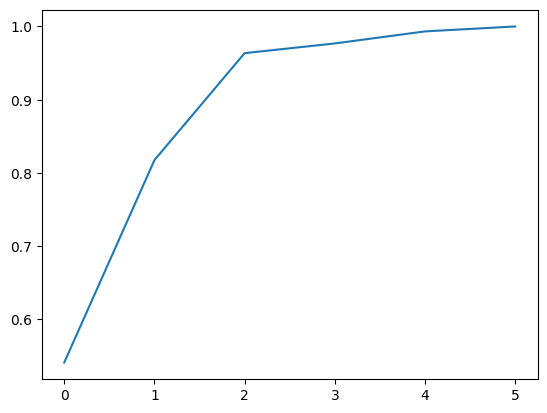

In [136]:
accuracys = [get_accuracy_min_max(out_animal,threshhold/10) for threshhold in range(3,9)]
plt.plot(accuracys)

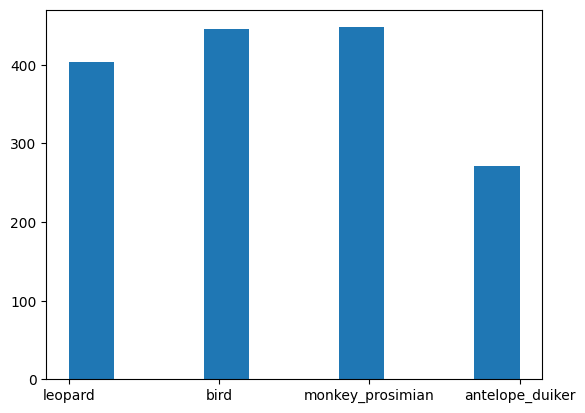

In [162]:
out_animal = df_merged.dropna()
out_animal = out_animal[out_animal["Phrases"] != "animal"]
out_animal = out_animal[out_animal["Logits"]>0.4]
plt.hist(out_animal[(out_animal["label"] == out_animal["Phrases"])]["Phrases"])
plt.show()

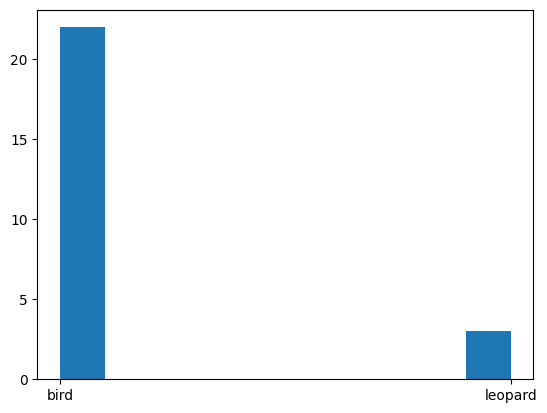

In [163]:
out_animal = df_merged.dropna()
out_animal = out_animal[out_animal["Phrases"] != "animal"]
out_animal = out_animal[out_animal["Logits"]>0.5]
plt.hist(out_animal[(out_animal["label"] != out_animal["Phrases"])]["Phrases"])
plt.show()

In [168]:
out_animal = df_merged.dropna()
out_animal = out_animal[out_animal["Phrases"] != "animal"]
out_animal = out_animal[out_animal["Logits"]>0.5]
out_animal[(out_animal["label"] != out_animal["Phrases"])]

,id,label,conf,Boxes,Logits,Phrases
771,ZJ000771,leopard,0.6880,"[0.61270314, 0.43066195, 0.054465473, 0.17065842]",0.519765,bird
1406,ZJ001406,civet_genet,0.9690,"[0.8113163, 0.5824624, 0.37666324, 0.7265203]",0.562929,leopard
1511,ZJ001511,rodent,0.8560,"[0.63034105, 0.34562826, 0.1066241, 0.18641216]",0.614381,bird
1884,ZJ001884,leopard,0.6070,"[0.6147548, 0.43170783, 0.06130413, 0.17130008]",0.519269,bird
2392,ZJ002392,monkey_prosimian,0.7320,"[0.4202476, 0.34990653, 0.0855943, 0.1581294]",0.675742,bird
2916,ZJ002916,monkey_prosimian,0.4740,"[0.2842095, 0.37562597, 0.10399752, 0.32829872]",0.509287,bird
2959,ZJ002959,monkey_prosimian,0.6120,"[0.42240396, 0.3467954, 0.08609488, 0.15642558]",0.615659,bird
3474,ZJ003474,civet_genet,0.8950,"[0.20268528, 0.8171232, 0.10554778, 0.3021225]",0.510814,bird
4527,ZJ004527,leopard,0.1900,"[0.6118811, 0.43559933, 0.054646384, 0.16337267]",0.530979,bird
4885,ZJ004885,monkey_prosimian,0.7460,"[0.28435227, 0.37539384, 0.1066283, 0.33647105]",0.673134,bird


In [60]:
blank_check = df_merged[pd.isna(df_merged["Phrases"])]
#blank_check = blank_check.drop(columns=["Boxes","Logits","Phrases"])
(blank_check[(blank_check["conf"]>0.05)==False]["label"] == "blank").mean()

0.5404450724125751

In [62]:
(df_merged[(df_merged["conf"]>0.05)==False]["label"] == "blank").mean()

0.529688972667295

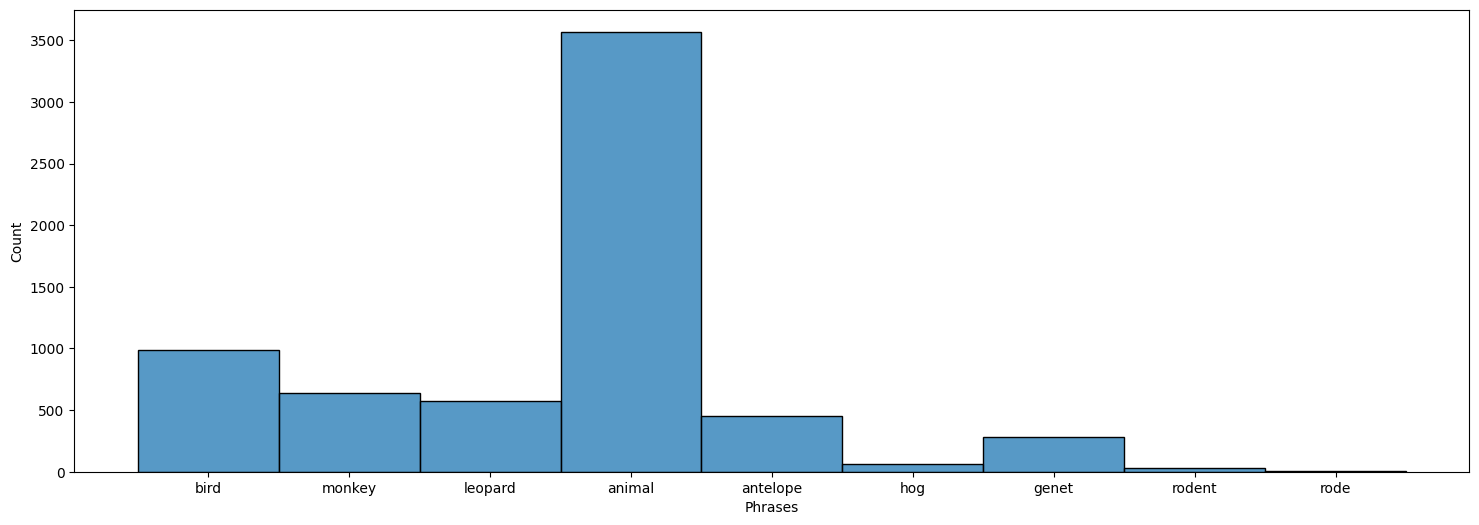

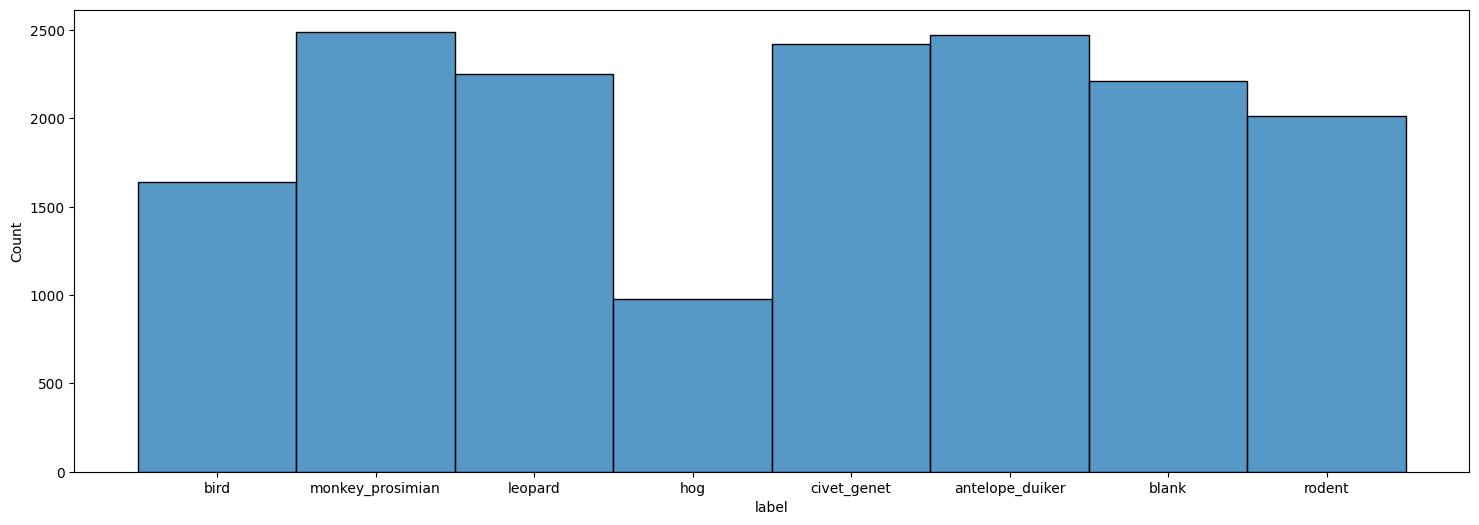

In [20]:
# df_merged["Phrases"].tolist()

import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(18,6))
sns.histplot(df_merged["Phrases"])
plt.show()
plt.subplots(figsize=(18,6))
sns.histplot(df_merged["label"])
plt.show()

TypeError: Image data of dtype <U27 cannot be converted to float

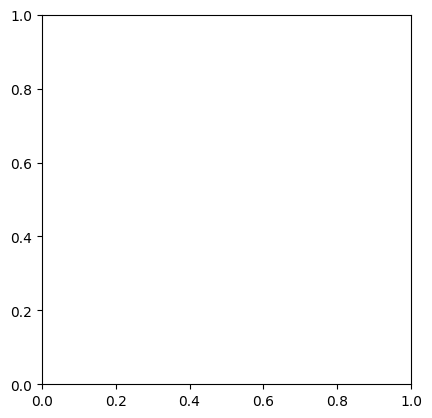

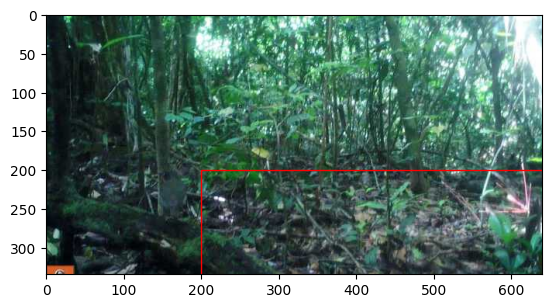

In [111]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(plt.imread("../competition_data/train_features/ZJ002031.jpg"))
rect = patches.Rectangle((200, 200), 500, 200, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [ ]:
import cv2

for bounding_box in predictions["predictions"]:
    x0 = bounding_box['x'] - bounding_box['width'] / 2
    x1 = bounding_box['x'] + bounding_box['width'] / 2
    y0 = bounding_box['y'] - bounding_box['height'] / 2
    y1 = bounding_box['y'] + bounding_box['height'] / 2
    
    start_point = (int(x0), int(y0))
    end_point = (int(x1), int(y1))
    cv2.rectangle(img, start_point, end_point, color=(0,255,0), thickness=2)
   
cv2.imwrite("example_with_bounding_boxes.jpg", image)

In [114]:
for i,v in enumerate(df_merged["Boxes"][3]):
    print(v)
    

[0.10790039 0.7786279  0.21284816 0.29499853]
[0.10781045 0.7788396  0.21293564 0.2949691 ]
